In [1]:
import pyspark.sql.functions as fn

In [109]:
import pandas as pd
import numpy as np

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

# Load from Parquet

In [4]:
df = spark.read.parquet('dataset/THB_cards.parquet')

In [5]:
df.createOrReplaceTempView("cards")

In [6]:
df.columns

['number',
 'rarity',
 'name',
 'convertedManaCost',
 'numColors',
 'colorIdentity',
 'encodedColorIdentity',
 'types',
 'encodedTypes',
 'subTypes',
 'encodedSubTypes',
 'superTypes',
 'encodedSuperTypes',
 'originalText',
 'filteredText',
 'power',
 'toughness']

## Groups 

### By color identity

In [76]:
df.groupby('colorIdentity').count().show()

+-------------+-----+
|colorIdentity|count|
+-------------+-----+
|          G,W|    4|
|            B|   45|
|          R,W|    2|
|          G,R|    4|
|            U|   45|
|          B,W|    3|
|          B,R|    4|
|          G,U|    3|
|            W|   48|
|            R|   44|
|          B,U|    6|
|            G|   44|
|          U,W|    3|
|             |   14|
|          B,G|    2|
|          R,U|    2|
+-------------+-----+



### From Models, show encoded types

In [77]:
from pyspark.ml.feature import StringIndexer, StringIndexerModel

In [78]:
indexer = StringIndexer.load("models/pyspark/stringindexer_str_types")
model = StringIndexerModel.load("models/pyspark/stringindexer_model_str_types")

In [79]:
model.labels

['Artifact',
 'Artifact,Creature',
 'Creature',
 'Enchantment',
 'Enchantment,Creature',
 'Instant',
 'Land',
 'Planeswalker',
 'Sorcery']

In [80]:
df.agg(fn.min(df.encodedTypes),fn.max(df.encodedTypes)).show()

+-----------------+-----------------+
|min(encodedTypes)|max(encodedTypes)|
+-----------------+-----------------+
|                0|                8|
+-----------------+-----------------+



### By color identity and encoded type

First, let's fetch the distinct color identities

In [119]:
pd_colorIdentities  = df.select("colorIdentity").alias("Color_Identity").distinct().sort("colorIdentity").toPandas()

In [120]:
pd_colorIdentities

,colorIdentity
0,
1,B
2,"B,G"
3,"B,R"
4,"B,U"
5,"B,W"
6,G
7,"G,R"
8,"G,U"
9,"G,W"


In [113]:
pd_encodedTypes = pd.DataFrame(np.arange(9), columns=['Encoded_Types'])

In [123]:
pd_encodedTypes

,Encoded_Types
0,0
1,1
2,2
3,3
4,4
5,5
6,6
7,7
8,8


Create a cartesian product of the color identities and the encoded types.

In [132]:
pd_colorIdentities['key'] = 0
pd_encodedTypes['key'] = 0

In [138]:
pd_cartesian = pd_colorIdentities.merge(pd_encodedTypes, how='outer').drop(columns=['key'])

In [146]:
pd_cartesian = pd_cartesian.rename(columns={'colorIdentity':'Color_Identity'})

In [147]:
pd_cartesian

,Color_Identity,Encoded_Types
0,,0
1,,1
2,,2
3,,3
4,,4
...,...,...
139,W,4
140,W,5
141,W,6
142,W,7


Now, let's create a list which will hold the following: ((color identity, encoded type), 1).

In [88]:
map1 = df.select(["colorIdentity", "encodedTypes"]).rdd.map(
    lambda x: ((x[0], x[1]), 1)
)

map1.take(10)

[(('B,G', 2), 1),
 (('B,R', 2), 1),
 (('G,W', 2), 1),
 (('R', 4), 1),
 (('G', 2), 1),
 (('G', 3), 1),
 (('R', 4), 1),
 (('G', 4), 1),
 (('U', 3), 1),
 (('B', 4), 1)]

Finally, let's compute the sum of the number of a found encoded types per color identity.

In [89]:
map2 = map1.reduceByKey(lambda a, b: a + b).sortByKey()

In [90]:
map2.take(5)

[(('', 0), 10), (('', 1), 1), (('', 6), 3), (('B', 2), 14), (('B', 3), 10)]

For convience, let's break down the (color identity, encoded type) key into a list of: (color identity, encoded type, sum). 

In [258]:
map3 = map2.map(lambda x: (x[0][0], x[0][1], x[1]))

In [259]:
pd_tab = map3.toDF().toPandas()

In [260]:
pd_tab.columns = ['Color_Identity', 'Encoded_Types', 'Total']

In [261]:
pd_tab.head(5)

,Color_Identity,Encoded_Types,Total
0,,0,10
1,,1,1
2,,6,3
3,B,2,14
4,B,3,10


Based on the color identity and encoded types, assign a key that corresponds to the cartesian product.

In [262]:
def assign_index(row):
    filter1 = pd_cartesian['Color_Identity'] ==  row['Color_Identity']
    filter2 = pd_cartesian['Encoded_Types'] == row['Encoded_Types']
    
    idx = pd_cartesian.index[filter1 & filter2].tolist()[0]

    return idx

In [263]:
pd_tab['Cart_Index'] = pd_tab.apply (lambda row: assign_index(row), axis=1)

In [264]:
pd_tab.head(5)

,Color_Identity,Encoded_Types,Total,Cart_Index
0,,0,10,0
1,,1,1,1
2,,6,3,6
3,B,2,14,11
4,B,3,10,12


Find the missing indexes from the cartesian product, and fill-in with "total = 0".

In [265]:
missing_cart_indexes = set(pd_cartesian.index.tolist()) - set(pd_tab.Cart_Index.tolist())

In [266]:
for index in missing_cart_indexes:
    row = pd_cartesian.iloc[index]

    new_df = row.copy()
    new_df['Total'] = 0
    new_df['Cart_Index'] = index
    
    pd_tab = pd_tab.append(new_df)

In [301]:
group_result = pd_tab.groupby('Encoded_Types')

In [303]:
group_result.groups

{0: Int64Index([0, 9, 18, 27, 36, 45, 54, 63, 72, 81, 90, 99, 108, 117, 126, 135], dtype='int64'),
 1: Int64Index([1, 10, 19, 28, 37, 46, 55, 64, 73, 82, 91, 100, 109, 118, 127,
             136],
            dtype='int64'),
 2: Int64Index([3, 9, 10, 13, 16, 19, 25, 28, 30, 33, 39, 41, 43, 49, 52, 2], dtype='int64'),
 3: Int64Index([4, 20, 29, 34, 44, 50, 53, 3, 21, 30, 39, 48, 66, 84, 102, 111], dtype='int64'),
 4: Int64Index([5, 17, 21, 26, 35, 40, 42, 45, 54, 4, 22, 31, 40, 76, 85, 130], dtype='int64'),
 5: Int64Index([6, 22, 36, 46, 55, 5, 23, 32, 41, 50, 68, 77, 86, 104, 113, 131], dtype='int64'),
 6: Int64Index([2, 7, 11, 14, 23, 27, 31, 37, 47, 51, 56, 24, 51, 78, 105, 114], dtype='int64'),
 7: Int64Index([15, 32, 57, 7, 16, 25, 34, 52, 61, 70, 79, 97, 106, 115, 124, 133], dtype='int64'),
 8: Int64Index([8, 12, 18, 24, 38, 48, 58, 8, 26, 44, 71, 80, 89, 107, 116, 134], dtype='int64')}

In [305]:
for group in group_result.groups.items():
    pass

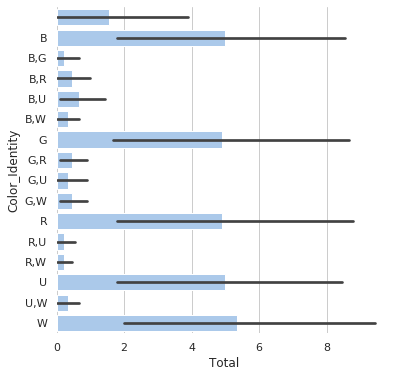

In [295]:
sns.set(style="whitegrid")

f, ax = plt.subplots(figsize=(6, 6))

sns.set_color_codes("pastel")
sns.barplot(x="Total", y="Color_Identity", data=pd_tab, label="Total", orient='h', color="b", )

sns.despine(left=True, bottom=True)

### Make an overall histogram from encoded types. 

In [96]:
hist = df.select("encodedTypes").rdd.flatMap(lambda x: x).histogram(9)

In [16]:
hist

([0.0,
  0.8888888888888888,
  1.7777777777777777,
  2.6666666666666665,
  3.5555555555555554,
  4.444444444444445,
  5.333333333333333,
  6.222222222222221,
  7.111111111111111,
  8],
 [10, 1, 100, 45, 50, 28, 13, 5, 21])

In [17]:
pd_hist = pd.DataFrame(data=list(zip(*hist)), columns=['bin', 'freq'])

In [18]:
pd_hist['perc'] = pd_hist['freq'] / pd_hist['freq'].sum()

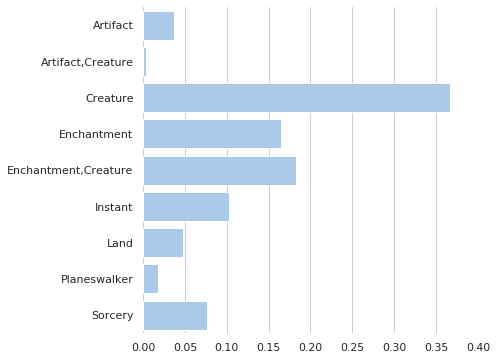

In [19]:
sns.set(style="whitegrid")

f, ax = plt.subplots(figsize=(6, 6))

sns.set_color_codes("pastel")
sns.barplot(x="perc", y="bin", data=pd_hist, label="Total", orient='h', color="b")

ax.set(xlim=(0, 0.4), xlabel="", ylabel="")
# ax.set(xlim=(0, 0.5), xlabel="%", ylabel="Creature type")
ax.set(yticklabels=model.labels)

sns.despine(left=True, bottom=True)

## SQL / FN

In [20]:
df.agg(*[fn.max(c).alias('max ' + c) for c in ['power', 'toughness']]).show()

+---------+-------------+
|max power|max toughness|
+---------+-------------+
|       10|            7|
+---------+-------------+



In [21]:
spark.sql("SELECT * FROM cards WHERE power == 10").show()

+------+------+------------+-----------------+---------+-------------+--------------------+--------+------------+--------+---------------+----------+-----------------+--------------------+--------------------+-----+---------+
|number|rarity|        name|convertedManaCost|numColors|colorIdentity|encodedColorIdentity|   types|encodedTypes|subTypes|encodedSubTypes|superTypes|encodedSuperTypes|        originalText|        filteredText|power|toughness|
+------+------+------------+-----------------+---------+-------------+--------------------+--------+------------+--------+---------------+----------+-----------------+--------------------+--------------------+-----+---------+
|   181|  rare|Nessian Boar|                5|        1|            G|                   6|Creature|           2|    Boar|              6|          |                0|All creatures abl...|All creatures abl...|   10|        6|
+------+------+------------+-----------------+---------+-------------+--------------------+-----

In [22]:
spark.sql("""
    SELECT * FROM cards
    ORDER BY power DESC, toughness DESC
    LIMIT 5
""").show()

+------+------+--------------------+-----------------+---------+-------------+--------------------+--------------------+------------+--------+---------------+----------+-----------------+--------------------+--------------------+-----+---------+
|number|rarity|                name|convertedManaCost|numColors|colorIdentity|encodedColorIdentity|               types|encodedTypes|subTypes|encodedSubTypes|superTypes|encodedSuperTypes|        originalText|        filteredText|power|toughness|
+------+------+--------------------+-----------------+---------+-------------+--------------------+--------------------+------------+--------+---------------+----------+-----------------+--------------------+--------------------+-----+---------+
|   181|  rare|        Nessian Boar|                5|        1|            G|                   6|            Creature|           2|    Boar|              6|          |                0|All creatures abl...|All creatures abl...|   10|        6|
|   297|  rare| 